# Tumor/T-cell model

We will walk through the creation of the multi-scale agent based model of T cell-tumor model. First we will describe and demonstrate testing of individual components called "processes" and then gradually introduce more complexity by connecting individually components together. 

In [53]:
#Import important packages for testing out the models throughout this jupyter notebook
#Vivarium Core modules needed
from vivarium.core.composition import simulate_composer
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.library.units import units, remove_units

#Process tumor-tcell modules needed
from tumor_tcell.processes.tumor import test_batch_tumor
from tumor_tcell.processes.tumor import get_timeline as get_timeline_tumor
from tumor_tcell.processes.t_cell import test_batch_t_cell
from tumor_tcell.processes.t_cell import get_timeline as get_timeline_tcell

#Composite tumor-tcell modules needed
from tumor_tcell.composites.t_cell_agent import TCellAgent
from tumor_tcell.composites.tumor_agent import TumorAgent
from tumor_tcell.composites.tumor_microenvironment import test_microenvironment, make_neighbors_config
from tumor_tcell.plots.snapshots import plot_snapshots

#Experiment tumor-tcell modules needed
from tumor_tcell.experiments.main import tumor_tcell_abm
from tumor_tcell.experiments.main import plots_suite
from tumor_tcell.experiments.main import get_tcells
from tumor_tcell.experiments.main import get_tumors

#Analysis tumor-tcell modules needed
from tumor_tcell.library.phylogeny import get_phylogeny

#Set out directory
outdir = 'out'

## Processes

The model is composed of two major cell types, each with two separate phenotpyes. Each cell has an associated process. The process for each cell type contains the fundamental rules that govern its behavior in interacting with the other cell types and with the inputs it receives from the environment.

Testing the processes individually enables understanding if underlying parameters derived from literature values or primary data accurately represent behavior expected based on such research. 

### Tumor

The tumor process is focused on two states of a tumor: proliferative with low levels of immune molecules (MHCI and PDL1) and quiescent with high levels of immune molecules (MHCI and PDL1). Its transition from the proliferative state is dependent on the level of interferon gamma it is exposed to coming from the T cells. Both tumor types can be killed by recieving cytotoxic packets from the T cells.

In this next cell, we use the function to test out an individual tumor process. 
* This uses a get_timeline_tumor function which feeds input to the tumor process we will plan on exposing it to when we combine it with the environment and other proceses.
* We can change variables like total_time (total simulation time in seconds), batch size (number of simulations to run for the process), timeline (preset inputs), and out_dir (save path for the plots) within the function test_batch_t_cell()


Experiment ID: 256c6a00-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:32:54
Completed in 2.21 seconds

Experiment ID: 26be0c88-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:32:56
Completed in 2.33 seconds

Experiment ID: 282221fe-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:32:58
Completed in 2.51 seconds


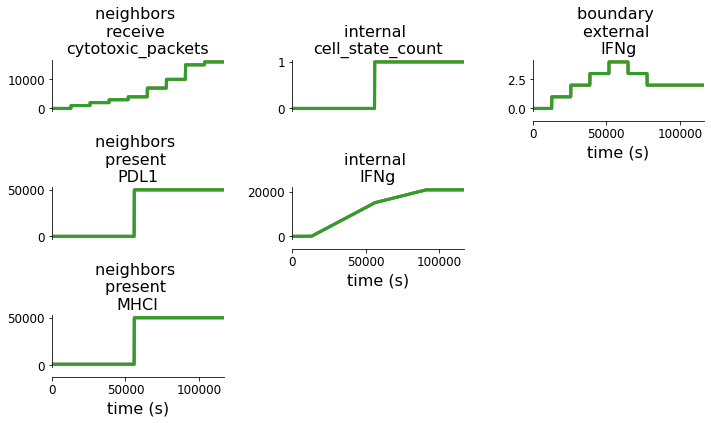

In [3]:
timeline = get_timeline_tumor()
test_batch_tumor(
#     total_time=10000,
    batch_size=3,
    timeline=timeline,
    out_dir=outdir)

The experiment ID is recorded for each experiment and parameters that are set to emit from the process are plotted. We can see that the cell is receiving increasing numbers of cytotoxic packets, and T cell death is recorded after the threshold is met.

### Tcell

The t cell process is focused on two states of a t cell: PD1- with increased secretion of immune molecules (IFNg and cytotoxic packets) and PD1+ with decreased secretion of immune molecules (IFNg and cytotoxic packets). These immune molecules have impact of the state and death of tumor cells. Its transition from the PD1- state is dependent on the length of time it is engaged with tumor cells. 

In this next cell, we use the function to test out an individual t cell process. 
* This uses a get_timeline_tcell function which feeds input to the t cell process we will plan on exposing it to when we combine it with the environment and other proceses.
* We can change variables like total_time (total simulation time in seconds), batch size (number of simulations to run for the process), timeline (preset inputs), and out_dir (save path for the plots) within the function test_batch_t_cell()


Experiment ID: 2e877dd2-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:33:09
Completed in 4.36 seconds

Experiment ID: 3121d704-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:33:14
Completed in 4.34 seconds

Experiment ID: 33b8f2cc-a850-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:33:18
Completed in 4.18 seconds


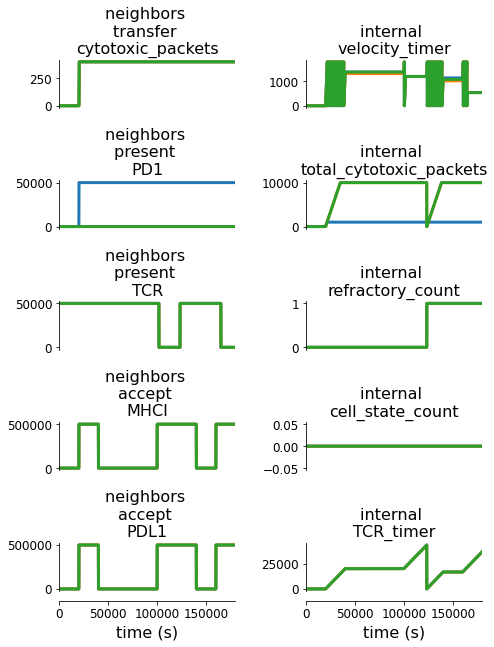

In [4]:
timeline = get_timeline_tcell()
test_batch_t_cell(
    batch_size=3,
    #total_time=100000,
    timeline=timeline,
    out_dir=outdir,
)

The experiment ID is recorded for each experiment and parameters that are set to emit from the process are plotted. We can see that the cell is secreting increasing numbers of cytotoxic packets, it downregulates TCR in response to being exposed to MHCI for extended times, and death occurs for different T cells.

## Composites

### Tcell agent

In [14]:
import os
os.getcwd()

'/mnt/c/Users/akoya-stanford/Python_Code/tumor-tcell/jupyter_notebooks'

In [15]:
total_time = 100000
agent_id = '0'
parameters = {'agent_id': agent_id}
composer = TCellAgent(parameters)

# settings for simulation and plot
initial = composer.initial_state()
initial['internal']['cell_state'] = 'PD1p'  # set an initial state
settings = {
    'initial_state': initial,
    'outer_path': ('agents', agent_id),
    'return_raw_data': True,
    'timestep': 60,
    'total_time': total_time}
tcell_agent_output = simulate_composer(composer, settings)


Experiment ID: ec9e4ef8-a851-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:45:38
Completed in 4.78 seconds


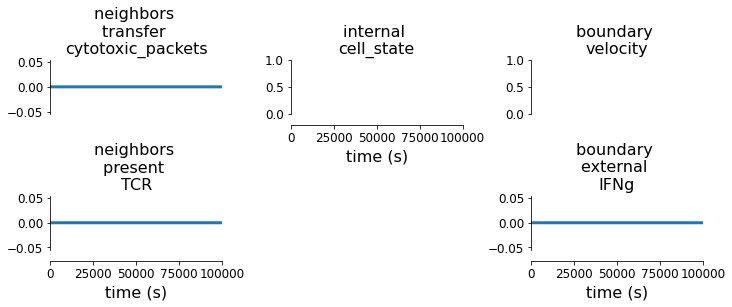

In [17]:
plot_settings = {}
fig = plot_agents_multigen(tcell_agent_output, plot_settings, out_dir =outdir)

### Tumor agent

In [36]:
total_time = 1000
agent_id = '0'
parameters = {'agent_id': agent_id}
composer = TumorAgent(parameters)

# settings for simulation and plot
initial = composer.initial_state()
initial['internal']['cell_state'] = 'PD1p'  # set an initial state
settings = {
    'initial_state': initial,
    'outer_path': ('agents', agent_id),
    'return_raw_data': True,
    'timestep': 10,
    'total_time': total_time}
tumor_agent_output = simulate_composer(composer, settings)


Experiment ID: ee16abec-a854-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 12:07:09
Completed in 0.029963 seconds


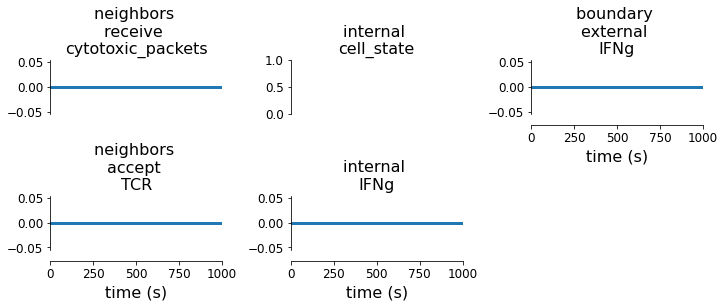

In [38]:
plot_settings = {}
fig = plot_agents_multigen(tumor_agent_output, plot_settings, out_dir =outdir)

### Tumor Microenvironment

In [29]:
bounds = [50 * units.um, 50 * units.um]
config = make_neighbors_config(bounds=bounds)

environment_data = test_microenvironment(config=config,
    n_agents=3,
    end_time=600)

# make snapshot plot
agents = {time: time_data['agents'] for time, time_data in environment_data.items()}
fields = {time: time_data['fields'] for time, time_data in environment_data.items()}
plot_data = {
    'agents': agents,
    'fields': fields,
    'config': {'bounds': remove_units(bounds)}}
plot_config = {
    'out_dir': outdir,
    'agent_shape': 'circle',
    'filename': 'snapshots'}
plot_snapshots(plot_data, plot_config)


Experiment ID: 6423364a-a853-11eb-b5fa-c8d9d2052175
Created: 04/28/2021 at 11:56:08
Completed in 2.17 seconds


KeyError: 0

## Experiments

In [54]:
##With simulated data
N_TUMORS = 120
N_TCELLS = 12
PD1n_per = 0.8
PDL1n_per = 0.6
DEFAULT_TUMORS = get_tumors(number=N_TUMORS, state_per=PD1n_per)
DEFAULT_TCELLS = get_tcells(number=N_TCELLS, state_per=PDL1n_per)

# global parameters
TIMESTEP = 60
BOUNDS = [200 * units.um, 200 * units.um]

data = tumor_tcell_abm(total_time=50000, tumors=DEFAULT_TUMORS, tcells=DEFAULT_TCELLS, 
                       halt_threshold=500,emit_step=60, bounds=BOUNDS,sim_step=10*TIMESTEP,)
data;

Initializing experiment tumor_tcell_20210428.123210


 46%|████▋     | 39/84 [01:04<01:13,  1.64s/it]


AttributeError: 'tuple' object has no attribute 'items'

In [43]:
data = remove_units(data)
data;

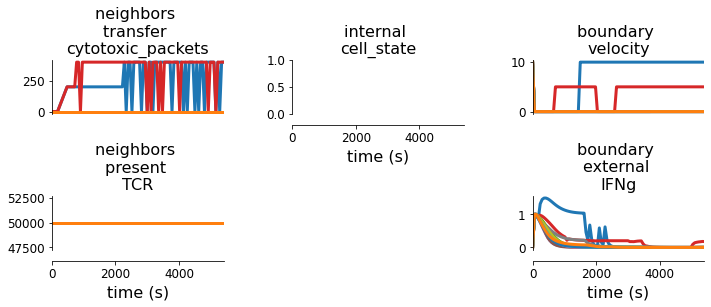

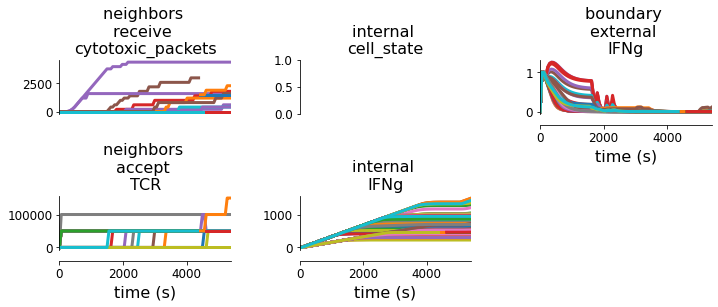

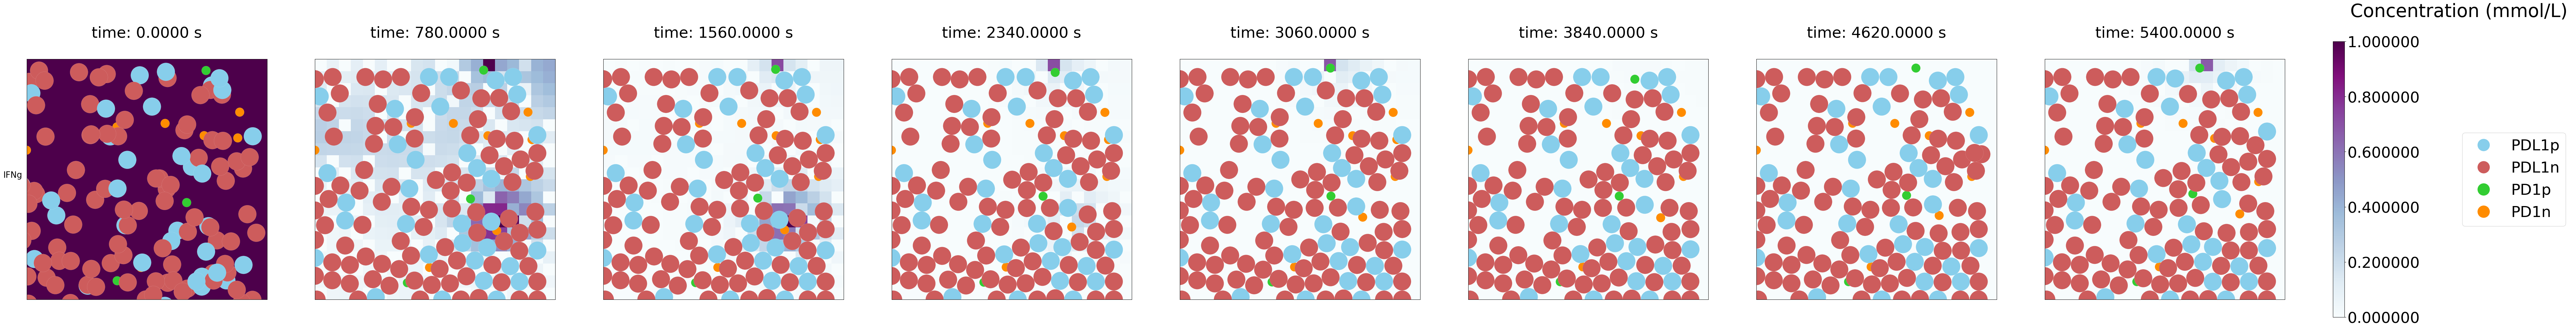

In [45]:
#Plot the data using tumor-tcell experiment notebook and save in current directory
fig1, fig2, fig3 = plots_suite(data, out_dir = outdir, bounds=[b*units.um for b in bounds])